In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 8.9 MB/s 
     |████████████████████████████████| 596 kB 61.1 MB/s 
     |████████████████████████████████| 86 kB 6.7 MB/s 
     |████████████████████████████████| 6.6 MB 54.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install pytorch-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 176 kB 6.6 MB/s 
     |████████████████████████████████| 880 kB 51.7 MB/s 
     |████████████████████████████████| 1.2 MB 44.1 MB/s 
     |████████████████████████████████| 132 kB 61.2 MB/s 
     |████████████████████████████████| 79 kB 3.5 MB/s 
     |████████████████████████████████| 8.8 MB 12.8 MB/s 
     |████████████████████████████████| 138 kB 62.7 MB/s 
     |████████████████████████████████| 127 kB 55.0 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=db23aefd89fb3adf28aa3e941e8083e1103c36eb021c6dc30f85d8a946fd201b
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras import utils as np_utils
from keras.utils.np_utils import to_categorical

import transformers
from transformers import AutoTokenizer,DistilBertModel, DistilBertConfig
from transformers import TFAutoModel

import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [5]:
# Downloading datasets
!rm -rf t*
!wget https://raw.githubusercontent.com/SreeBhagya-S/Conference_22/main/manglish_test.tsv;
!wget https://raw.githubusercontent.com/SreeBhagya-S/Conference_22/main/manglish_train.csv;

--2022-05-27 07:11:40--  https://raw.githubusercontent.com/SreeBhagya-S/Conference_22/main/manglish_test.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113620 (111K) [text/plain]
Saving to: ‘manglish_test.tsv’

manglish_test.tsv   100%[===================>] 110.96K  --.-KB/s    in 0.01s   

2022-05-27 07:11:40 (8.90 MB/s) - ‘manglish_test.tsv’ saved [113620/113620]

--2022-05-27 07:11:41--  https://raw.githubusercontent.com/SreeBhagya-S/Conference_22/main/manglish_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4058

In [6]:
df = pd.read_csv('/content/manglish_train.csv',  sep=',', header=0)
df_test = pd.read_csv('/content/manglish_test.tsv',  sep='\t', header=0)

In [7]:
df = df.dropna()

df_test = df_test.dropna()


In [8]:
df

,text,category
0,hoo mammokka police vesham aaha anthas,Positive
1,Oru rekshayum illa...kidilam kannu nananjupoyi,Positive
2,Ikka waiting.........,Positive
3,Raju Ettante Oro Shorttum Ijathi ppwli,Positive
4,Ettan fansil netti poya aarenkilum undo? #m...,Positive
...,...,...
5495,Nowdays malayalam cinema is like telugu cinema,not-malayalam
5496,Superb trailer I have ever seen.,not-malayalam
5497,Superb song n Excellent visuals,not-malayalam
5498,please tell movie release date ..,not-malayalam


In [9]:
from bs4 import BeautifulSoup

import nltk, string, re, spacy,unicodedata, random
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
def preprocess_text(text):
    text = text.lower()
    text = text.strip()
    text = re.sub(r"http\S+", "", text, flags=re.MULTILINE)  # removing urls
    text = re.sub(r"www\S+", "", text, flags=re.MULTILINE)  # removing urls
    text = re.sub(r"&\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"\.{2,}", ".", text, flags=re.MULTILINE)  # continous dots
    text = re.sub(r"&", " and ", text)

    for i in [8221, 35, 36, 94, 8217]:
        text = text.replace(chr(i), "")
    text = text.replace("\n", ".")
    text = text.replace("&amp", " ")
    text = text.replace("-", "")
    text = text.replace(";", "")
    text = text.replace("@", "")
    text = text.replace('[{}]'.format(string.punctuation), '') #removing punctuations
    punctuation = '!!"$%&()*+-/:;<=>?[\\]^_{|}~.'
    text = ''.join(ch for ch in text if ch not in set(punctuation))
    # text = text.translate(str.maketrans('', '', string.punctuation))
    text = BeautifulSoup(text, 'html.parser').get_text()
      # Stopword Removing using nltk
    tokenizer = ToktokTokenizer()
    # convert sentence into token of words
    tokens = tokenizer.tokenize(text)
   # tokens = [token.strip() for token in tokens if token not in STOP_WORDS]
    text = ' '.join(ch for ch in tokens)
    return text

In [11]:
def process_data(df):
    df["text"] = df["text"].map(lambda x: preprocess_text(x))
    return df

In [12]:
df = process_data(df)
df_test = process_data(df_test)

In [13]:
df

,text,category
0,hoo mammokka police vesham aaha anthas,Positive
1,oru rekshayum illakidilam kannu nananjupoyi,Positive
2,ikka waiting,Positive
3,raju ettante oro shorttum ijathi ppwli,Positive
4,ettan fansil netti poya aarenkilum undo madura...,Positive
...,...,...
5495,nowdays malayalam cinema is like telugu cinema,not-malayalam
5496,superb trailer i have ever seen,not-malayalam
5497,superb song n excellent visuals,not-malayalam
5498,please tell movie release date,not-malayalam


In [14]:
labels = ['Mixed_feelings','Negative','Positive','not-malayalam ','unknown_state']


In [15]:
X_train = df.text
X_test = df_test.text

y_train = df.category
y_test = df_test.category

(array([7.020e+02, 3.419e+03, 1.063e+03, 2.530e+02, 4.700e+01, 6.000e+00,
        5.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([ 1. ,  5.4,  9.8, 14.2, 18.6, 23. , 27.4, 31.8, 36.2, 40.6, 45. ]),
 <a list of 10 Patch objects>)

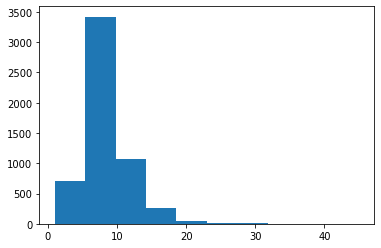

In [16]:
train_lens = [len(i.split()) for i in X_train]
plt.hist(train_lens)

In [17]:
y_train.shape

(5498,)

In [18]:
y_train.value_counts()

Positive          2081
unknown_state     1400
not-malayalam      848
Negative           726
Mixed_feelings     443
Name: category, dtype: int64

In [19]:
y_test.shape

(1348,)

In [20]:
y_test.value_counts()

Positive          565
unknown_state     398
not-malayalam     177
Negative          138
Mixed_feelings     70
Name: category, dtype: int64

In [21]:
encoder = LabelEncoder()
encoder.fit(y_train)

y_train = encoder.transform(y_train)
encoder.fit(y_test)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [22]:
# Tokenization of the data
def text_encode(text, tokenizer, max_len=100):
    tokens = text.apply(lambda x: tokenizer(x,return_tensors='tf', 
                                            truncation=True,
                                            padding='max_length',
                                            max_length=max_len, 
                                            add_special_tokens=True))
    input_ids= []
    attention_mask=[]
    for item in tokens:
        input_ids.append(item['input_ids'])
        attention_mask.append(item['attention_mask'])
    input_ids, attention_mask=np.squeeze(input_ids), np.squeeze(attention_mask)

    return [input_ids,attention_mask]

In [23]:
from tensorflow.keras.layers import BatchNormalization

In [24]:
# model creation
def build_model(b_model, maxlen):
   input_ids = tf.keras.Input(shape=(maxlen,),dtype=tf.int32, name='input_ids')
   attention_mask = tf.keras.Input(shape=(maxlen,),dtype=tf.int32, name='attention_mask')

   sequence_output = b_model(input_ids,attention_mask=attention_mask)
   output = sequence_output[0][:,0,:]
   output = tf.keras.layers.Dense(32,activation='relu')(output)

   output = tf.keras.layers.Dropout(0.1)(output)
   output = tf.keras.layers.Dense(5,activation='softmax')(output)

   model = tf.keras.models.Model(inputs = [input_ids,attention_mask], outputs = [output])
   
   model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

   return model

In [25]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

**XLM**

In [ ]:
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig

In [ ]:
# Creating tokenizer
tokenizer_xlm = AutoTokenizer.from_pretrained('xlm-clm-enfr-1024')
pt_xlm = TFAutoModel.from_pretrained('xlm-clm-enfr-1024')

Some layers from the model checkpoint at xlm-clm-enfr-1024 were not used when initializing TFXLMModel: ['pred_layer_._proj']
- This IS expected if you are initializing TFXLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMModel were initialized from the model checkpoint at xlm-clm-enfr-1024.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMModel for predictions without further training.


In [ ]:
X_train_input_ids, X_train_attention_mask = text_encode(X_train, tokenizer_xlm, max_len=100)
X_test_input_ids, X_test_attention_mask = text_encode(X_test, tokenizer_xlm, max_len=100)

In [ ]:
model = build_model(pt_xlm, maxlen=100)

In [ ]:
history = model.fit(
    [X_train_input_ids, X_train_attention_mask],
    y_train,
    batch_size=32,
    validation_data=([X_test_input_ids, X_test_attention_mask], y_test),
    epochs=10
)

Epoch 1/10
172/172 [==============================] - 125s 533ms/step - loss: 1.5498 - accuracy: 0.3603 - val_loss: 1.3093 - val_accuracy: 0.4273
Epoch 2/10
172/172 [==============================] - 91s 528ms/step - loss: 1.3860 - accuracy: 0.4505 - val_loss: 1.3043 - val_accuracy: 0.4444
Epoch 3/10
172/172 [==============================] - 91s 529ms/step - loss: 1.2311 - accuracy: 0.5136 - val_loss: 1.1166 - val_accuracy: 0.5601
Epoch 4/10
172/172 [==============================] - 91s 530ms/step - loss: 1.1455 - accuracy: 0.5489 - val_loss: 1.0230 - val_accuracy: 0.6128
Epoch 5/10
172/172 [==============================] - 91s 529ms/step - loss: 1.0662 - accuracy: 0.5895 - val_loss: 0.9810 - val_accuracy: 0.6202
Epoch 6/10
172/172 [==============================] - 91s 529ms/step - loss: 0.9897 - accuracy: 0.6195 - val_loss: 0.9554 - val_accuracy: 0.6335
Epoch 7/10
172/172 [==============================] - 91s 529ms/step - loss: 0.9363 - accuracy: 0.6437 - val_loss: 0.9430 - val_a

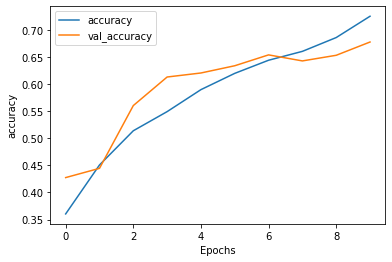

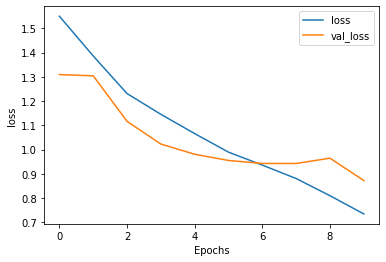

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
y_predicted = model.predict([X_test_input_ids, X_test_attention_mask])

In [ ]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(y_predicted,axis=1), target_names=labels))

                precision    recall  f1-score   support

Mixed_feelings       0.37      0.33      0.35        70
      Negative       0.55      0.59      0.57       138
      Positive       0.77      0.73      0.75       565
not-malayalam        0.75      0.69      0.72       177
 unknown_state       0.62      0.68      0.65       398

      accuracy                           0.68      1348
     macro avg       0.61      0.61      0.61      1348
  weighted avg       0.68      0.68      0.68      1348



**XLNET**

In [ ]:
from transformers import XLNetTokenizer, XLNetModel

In [ ]:
# Creating tokenizer
tokenizer_xlnet = AutoTokenizer.from_pretrained('xlnet-base-cased')
pt_xlnet = TFAutoModel.from_pretrained('xlnet-base-cased')

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


In [ ]:
X_train_input_ids, X_train_attention_mask = text_encode(X_train, tokenizer_xlnet, max_len=100)
X_test_input_ids, X_test_attention_mask = text_encode(X_test, tokenizer_xlnet, max_len=100)

In [ ]:
model = build_model(pt_xlnet, maxlen=100)

In [ ]:
history = model.fit(
    [X_train_input_ids, X_train_attention_mask],
    y_train,
    batch_size=32,
    validation_data=([X_test_input_ids, X_test_attention_mask], y_test),
    epochs=10
)

Epoch 1/10
172/172 [==============================] - 162s 867ms/step - loss: 1.5139 - accuracy: 0.3827 - val_loss: 1.2181 - val_accuracy: 0.4792
Epoch 2/10
172/172 [==============================] - 147s 853ms/step - loss: 1.2839 - accuracy: 0.4731 - val_loss: 1.0707 - val_accuracy: 0.5690
Epoch 3/10
172/172 [==============================] - 147s 853ms/step - loss: 1.1889 - accuracy: 0.5222 - val_loss: 1.0205 - val_accuracy: 0.5786
Epoch 4/10
172/172 [==============================] - 147s 852ms/step - loss: 1.0730 - accuracy: 0.5780 - val_loss: 0.9787 - val_accuracy: 0.6009
Epoch 5/10
172/172 [==============================] - 147s 853ms/step - loss: 0.9827 - accuracy: 0.6168 - val_loss: 0.9040 - val_accuracy: 0.6269
Epoch 6/10
172/172 [==============================] - 147s 853ms/step - loss: 0.9117 - accuracy: 0.6424 - val_loss: 0.9395 - val_accuracy: 0.6543
Epoch 7/10
172/172 [==============================] - 147s 853ms/step - loss: 0.8450 - accuracy: 0.6770 - val_loss: 0.9067 -

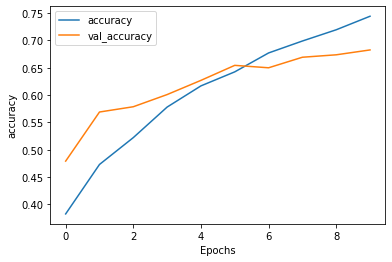

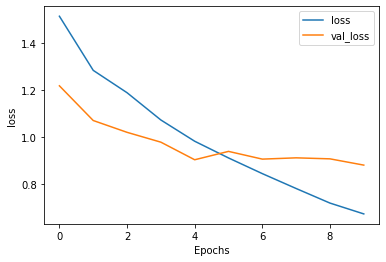

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
y_predicted = model.predict([X_test_input_ids, X_test_attention_mask])

In [ ]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(y_predicted,axis=1), target_names=labels))

                precision    recall  f1-score   support

Mixed_feelings       0.44      0.39      0.41        70
      Negative       0.52      0.50      0.51       138
      Positive       0.72      0.79      0.75       565
not-malayalam        0.73      0.88      0.79       177
 unknown_state       0.70      0.56      0.62       398

      accuracy                           0.68      1348
     macro avg       0.62      0.62      0.62      1348
  weighted avg       0.68      0.68      0.68      1348



**mBert**

In [ ]:
from transformers.models import bert
from transformers import BertTokenizer

In [ ]:
# Creating tokenizer
#tokenizer_bert = AutoTokenizer.from_pretrained('bert-base-uncased')
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=False)

pt_bert = TFAutoModel.from_pretrained('bert-base-multilingual-uncased')

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
for layer in pt_bert.layers:
      layer.trainable = True

In [ ]:
X_train_input_ids, X_train_attention_mask = text_encode(X_train, tokenizer_bert, max_len=100)
X_test_input_ids, X_test_attention_mask = text_encode(X_test, tokenizer_bert, max_len=100)

In [ ]:
model = build_model(pt_bert, maxlen=100)

In [ ]:
history = model.fit(
    [X_train_input_ids, X_train_attention_mask],
    y_train,
    batch_size=32,
    validation_data=([X_test_input_ids, X_test_attention_mask], y_test),
    epochs=10,
)

Epoch 1/10
172/172 [==============================] - 135s 701ms/step - loss: 1.2541 - accuracy: 0.4782 - val_loss: 1.0647 - val_accuracy: 0.5935
Epoch 2/10
172/172 [==============================] - 119s 691ms/step - loss: 0.9726 - accuracy: 0.6168 - val_loss: 0.8768 - val_accuracy: 0.6588
Epoch 3/10
172/172 [==============================] - 119s 691ms/step - loss: 0.7986 - accuracy: 0.6899 - val_loss: 0.8355 - val_accuracy: 0.6832
Epoch 4/10
172/172 [==============================] - 119s 692ms/step - loss: 0.6455 - accuracy: 0.7565 - val_loss: 0.8402 - val_accuracy: 0.6914
Epoch 5/10
172/172 [==============================] - 119s 691ms/step - loss: 0.5296 - accuracy: 0.8045 - val_loss: 0.8742 - val_accuracy: 0.6877
Epoch 6/10
172/172 [==============================] - 119s 691ms/step - loss: 0.4357 - accuracy: 0.8439 - val_loss: 0.9487 - val_accuracy: 0.7003
Epoch 7/10
172/172 [==============================] - 119s 691ms/step - loss: 0.3223 - accuracy: 0.8840 - val_loss: 0.9657 -

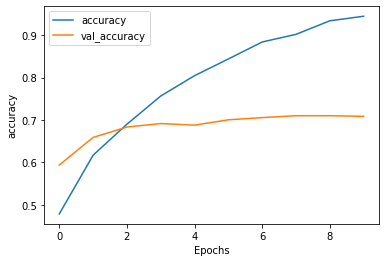

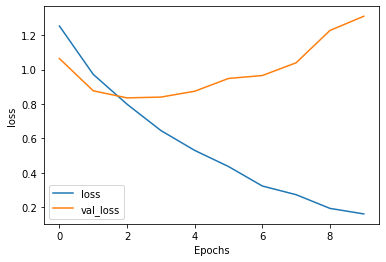

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
y_predicted = model.predict([X_test_input_ids, X_test_attention_mask])

In [ ]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(y_predicted,axis=1), target_names=labels))

**Distil Bert**

In [26]:
from transformers.models import distilbert
from transformers import DistilBertTokenizer

In [27]:
tokenizer_dbert  = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [29]:
pt_dbert = TFAutoModel.from_pretrained('distilbert-base-multilingual-cased')

Downloading:   0%|          | 0.00/869M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [30]:
for layer in pt_dbert.layers:
      layer.trainable = True

In [31]:
X_train_input_ids, X_train_attention_mask = text_encode(X_train, tokenizer_dbert, max_len=100)
X_test_input_ids, X_test_attention_mask = text_encode(X_test, tokenizer_dbert, max_len=100)

In [32]:
model = build_model(pt_dbert, maxlen=100)

In [38]:
history = model.fit(
    [X_train_input_ids, X_train_attention_mask],
    y_train,
    batch_size=32,
    validation_data=([X_test_input_ids, X_test_attention_mask], y_test),
    epochs=10
)

Epoch 9/10
172/172 [==============================] - 65s 376ms/step - loss: 0.0302 - accuracy: 0.9913 - val_loss: 1.7122 - val_accuracy: 0.6892
Epoch 10/10
172/172 [==============================] - 65s 376ms/step - loss: 0.0368 - accuracy: 0.9882 - val_loss: 1.7426 - val_accuracy: 0.6981


In [34]:
loss, accuracy = model.evaluate([X_test_input_ids, X_test_attention_mask], y_test)
print('Test accuracy :', accuracy*100,"%")

43/43 [==============================] - 5s 112ms/step - loss: 1.2778 - accuracy: 0.7136
Test accuracy : 71.36498689651489 %


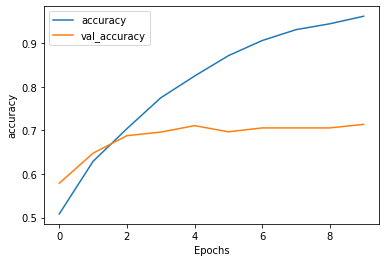

In [35]:
plot_graphs(history, "accuracy")
#plot_graphs(history, "loss")

In [36]:
y_predicted = model.predict([X_test_input_ids, X_test_attention_mask])
print(classification_report(np.argmax(y_test,axis=1),np.argmax(y_predicted,axis=1), target_names=labels))

                precision    recall  f1-score   support

Mixed_feelings       0.52      0.46      0.49        70
      Negative       0.59      0.57      0.58       138
      Positive       0.76      0.79      0.78       565
not-malayalam        0.77      0.80      0.78       177
 unknown_state       0.69      0.66      0.67       398

      accuracy                           0.71      1348
     macro avg       0.67      0.66      0.66      1348
  weighted avg       0.71      0.71      0.71      1348



**RoBERTa**

In [37]:
from transformers.models import roberta

In [39]:
# Creating tokenizer
tokenizer_rbert = AutoTokenizer.from_pretrained('roberta-base')
pt_rbert = TFAutoModel.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [40]:
for layer in pt_rbert.layers:
      layer.trainable = True

In [41]:
X_train_input_ids, X_train_attention_mask = text_encode(X_train, tokenizer_rbert, max_len=100)
X_test_input_ids, X_test_attention_mask = text_encode(X_test, tokenizer_rbert, max_len=100)

In [42]:
model = build_model(pt_rbert, maxlen=100)

In [43]:
history = model.fit(
    [X_train_input_ids, X_train_attention_mask],
    y_train,
    batch_size=32,
    validation_data=([X_test_input_ids, X_test_attention_mask], y_test),
    epochs=10
)

Epoch 1/10
172/172 [==============================] - 136s 705ms/step - loss: 1.2979 - accuracy: 0.4600 - val_loss: 1.0533 - val_accuracy: 0.5890
Epoch 2/10
172/172 [==============================] - 118s 687ms/step - loss: 1.0640 - accuracy: 0.5777 - val_loss: 0.9467 - val_accuracy: 0.6343
Epoch 3/10
172/172 [==============================] - 118s 687ms/step - loss: 0.9212 - accuracy: 0.6371 - val_loss: 0.8944 - val_accuracy: 0.6580
Epoch 4/10
172/172 [==============================] - 118s 687ms/step - loss: 0.8113 - accuracy: 0.6826 - val_loss: 0.8817 - val_accuracy: 0.6758
Epoch 5/10
172/172 [==============================] - 118s 687ms/step - loss: 0.7070 - accuracy: 0.7335 - val_loss: 0.8700 - val_accuracy: 0.6899
Epoch 6/10
172/172 [==============================] - 118s 688ms/step - loss: 0.6324 - accuracy: 0.7630 - val_loss: 0.8979 - val_accuracy: 0.6840
Epoch 7/10
172/172 [==============================] - 118s 686ms/step - loss: 0.5390 - accuracy: 0.7997 - val_loss: 0.9294 -

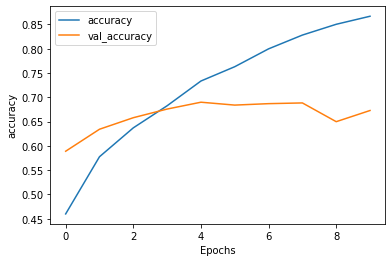

In [44]:
plot_graphs(history, "accuracy")
#plot_graphs(history, "loss")

In [45]:
y_predicted = model.predict([X_test_input_ids, X_test_attention_mask])

In [46]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(y_predicted,axis=1), target_names=labels))

                precision    recall  f1-score   support

Mixed_feelings       0.37      0.50      0.43        70
      Negative       0.45      0.69      0.54       138
      Positive       0.75      0.79      0.77       565
not-malayalam        0.73      0.78      0.75       177
 unknown_state       0.75      0.48      0.59       398

      accuracy                           0.67      1348
     macro avg       0.61      0.65      0.62      1348
  weighted avg       0.70      0.67      0.67      1348

